# Oregon Wildlife - Image Classification Capstone - Baseline Modeling
## David Lappin
### BrainStation
#### 3/1/2023 -

Packages Import:

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL 
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Import Data:

In [9]:
#set local path to files for basic exploration

datapath = 'data/oregon_wildlife/' # This is the relative path to the data
image_files = os.listdir(datapath) #these are the individual folder names (the class names)

Ensure Data is still in the same state as we left it from the previous EDA before modeling.

Everything looks the same. The data is mostly balanced with no significant outliers. We can move on to splitting and modelling the data.

# Split data:

In [17]:
#define loading parameters 

batch_size = 32 #use batch size of 32 images 
img_height = 180 
img_width = 180


For now we are goin to leave the hieght and widgth at 180x180. If we need to reduce the complexity of the photos later for modeling we can reduce these values.

In [18]:
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  datapath,
  validation_split=0.2,
  subset="training",
  label_mode='int',
  seed=7,
  image_size=(img_height, img_width),
  batch_size=batch_size)


val_set = tf.keras.preprocessing.image_dataset_from_directory(
  datapath,
  validation_split=0.2,
  subset="validation",
  label_mode='int',
  seed=7,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 13550 files belonging to 20 classes.
Using 10840 files for training.
Found 13550 files belonging to 20 classes.
Using 2710 files for validation.


# Create and Compile Baseline Model

Similar to our preliminary compatibility testing in the EDA section we are going to create a simple Convolutional Neural Network (CNN) based in TF/Keras for our baseline model.

In [19]:
#save and check class_names in the training set

class_names = train_set.class_names
len(class_names)


20

Below:
- **Autotune** allows for CPU performance optimizaiton
- **Cache** - stores imported images in memory for future epoch iterations
- **prefetch** - allows for overlapping of preprocess and training

In [20]:
#adjust the prefetching for performance

AUTOTUNE = tf.data.AUTOTUNE #Autotune optimizes CPU uptime for each batch

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) #cache stores data in memory after 1st epoch for faster iterations
val_set = val_set.cache().prefetch(buffer_size=AUTOTUNE) #prefetch allows for overlapping 



A basic CNN including three convolutions and Maxpooling layers, one dense layer and an output layer equal to the number of classes present in the data (20).

**NOTE:** Per Tensorflow guidance: "This model has not been tuned for high accuracy". This model construction will serve as a basic baseline to build off of.

In [21]:
#build model 

num_classes = len(class_names) # define the number of classes

#define model sequential
model = Sequential([
 
  #include rescaling layer directly in model build  
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  
  #include the convolution blocks with max pooling layers, and 'relu' activation  
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  #flatten   
  layers.Flatten(),
    
  #dense layer (single) with relu activation  
  layers.Dense(128, activation='relu'),
    
  #output later with num_classes (20)   
  layers.Dense(num_classes, activation = 'softmax')
])


Compile the model using:
- Adam Optimzer (high performing gradient decent method, default learning rate = 0.001)
 - note there are other options but we will stick with Adam
- SparseCategoricalCrossentropy loss calcualtion  (used when there are more than two classes or labels)

In [22]:
#compile the model

model.compile(optimizer='adam',
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])

In [23]:
#look at the compiled model summary 

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In our baseline model we have now compiled all the layers. There are ~4million trainable parameters, and we see our output layer is 20 which matches our class labels. 

Next we can fit our model to the training data using 10 epochs. Our model will be validated on the validation split. The test set will be saved for predictions later. 

In [24]:
#fit model for 10 epochs

epochs = 3

history = model.fit(   
  train_set,            
  validation_data=val_set, 
  epochs=epochs            
)

Epoch 1/3
339/339 [==============================] - 143s 344ms/step - loss: 2.6204 - accuracy: 0.1950 - val_loss: 2.2507 - val_accuracy: 0.3166
Epoch 2/3
339/339 [==============================] - 103s 305ms/step - loss: 1.8641 - accuracy: 0.4512 - val_loss: 1.7314 - val_accuracy: 0.4937
Epoch 3/3
339/339 [==============================] - 95s 279ms/step - loss: 0.9814 - accuracy: 0.7179 - val_loss: 1.2313 - val_accuracy: 0.6915


Save the model:

In [79]:
#save the model weights for use in predictions later if desired

#model.save('Baseline_Actual10.h5')

#### Observations:

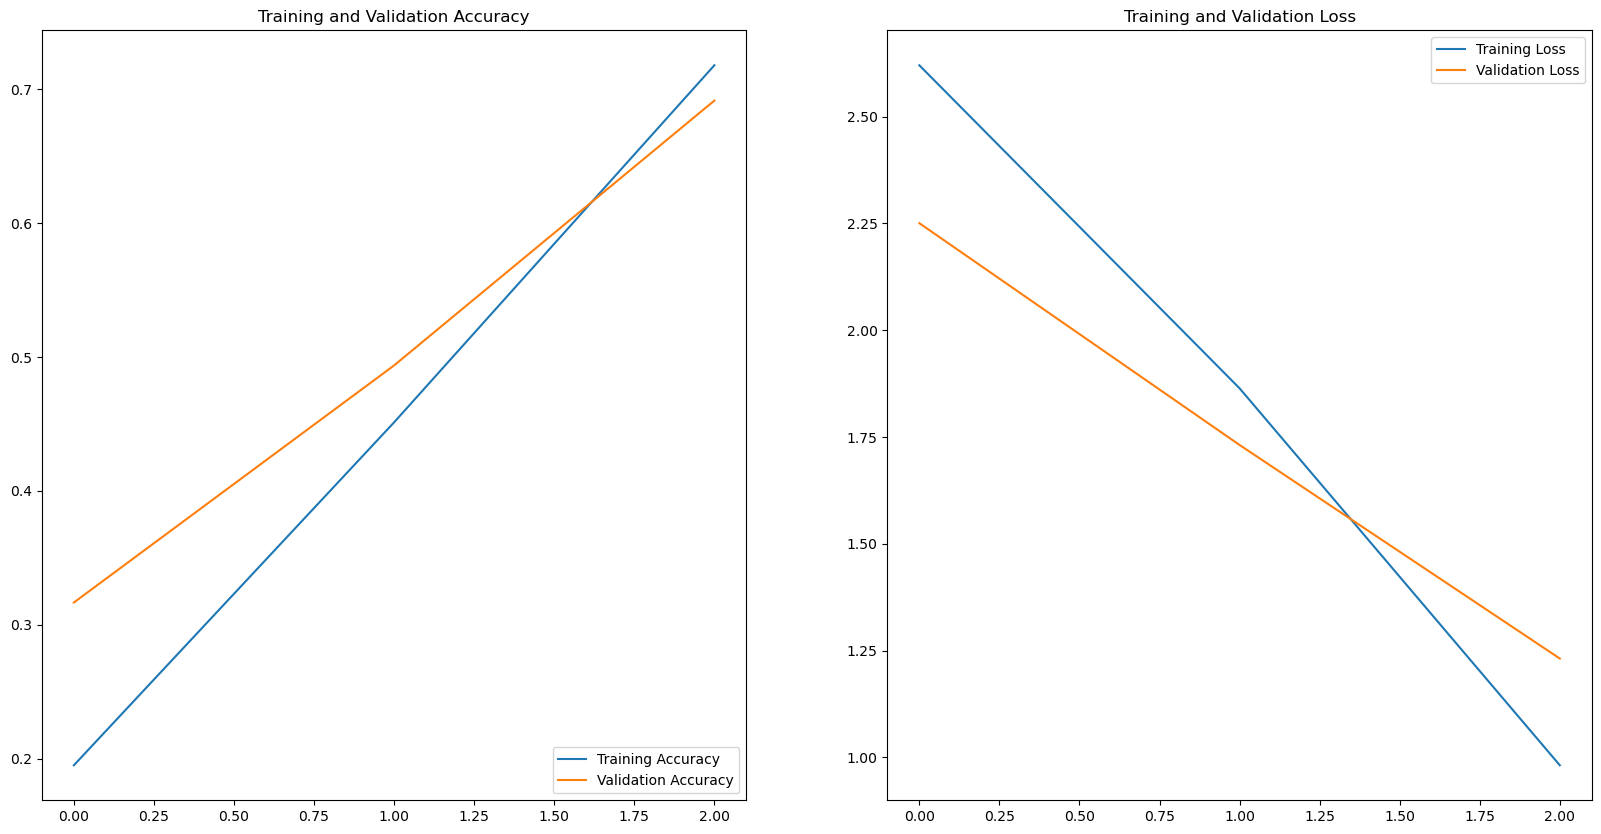

In [25]:
#visualize model performance (plots code ref from TF guide)


#pull out the accuracy and validation accuracies from model fit history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#pull out the loss data from the model fit history
loss = history.history['loss']
val_loss = history.history['val_loss']

#x lab range defined by the # of epochs ran
epochs_range = range(epochs)

#trainig vs Validation Accuracies
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#visualize loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [35]:
test_set = tf.keras.preprocessing.image_dataset_from_directory(
  ('data\\oregon_wildlife_test\\'),
  image_size=(img_height, img_width),
  label_mode = 'categorical')

Found 400 files belonging to 20 classes.


In [56]:
predictions = np.array([])
labels =  np.array([])
for x, y in test_set:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
    

1/1 [==============================] - 0s 38ms/step


In [57]:
con_mat = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

In [58]:
normalized_conf_mat = con_mat / con_mat.sum(axis=1)

In [60]:
class_names = test_set.class_names
con_mat_df = pd.DataFrame(normalized_conf_mat, index=class_names, columns=class_names)

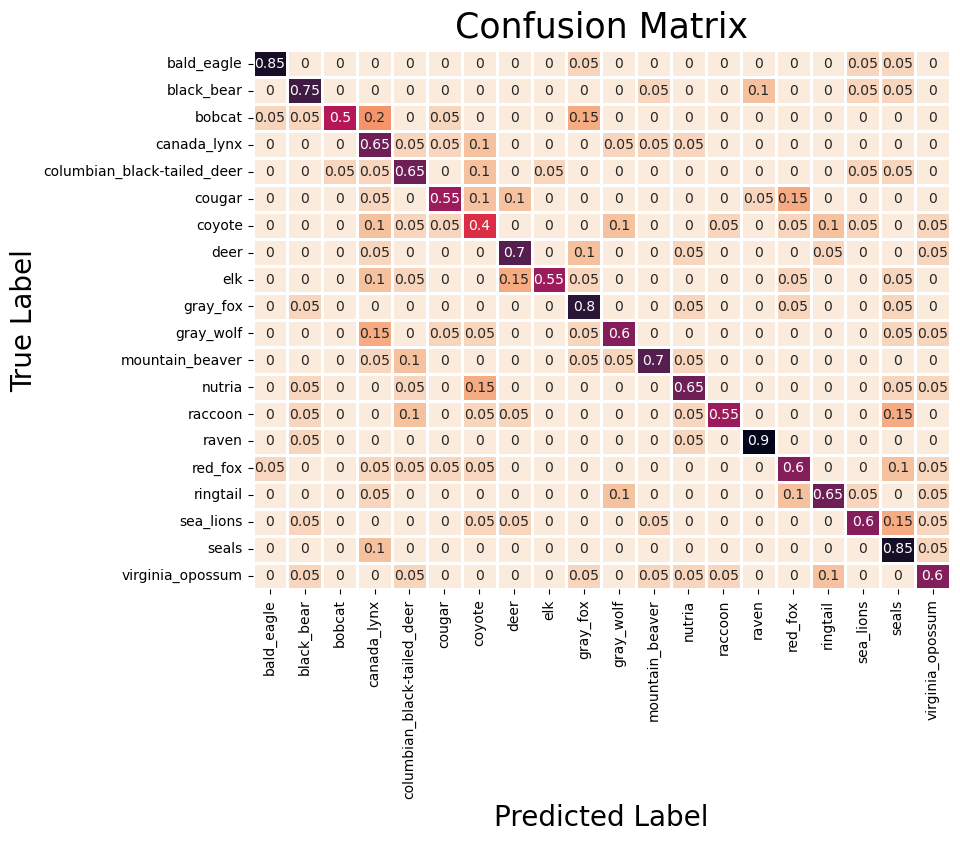

In [61]:
import seaborn as sns
plt.figure(figsize = (9,7))
sns.heatmap(con_mat_df,
            annot=True,
            cbar=False,
            cmap="rocket_r",
            linewidths=1
           )
plt.title('Confusion Matrix',size = 25,y=1.01)
plt.xlabel("Predicted Label", size = 20)
plt.ylabel("True Label", size = 20)
plt.show()

Is there data leakage???

https://datascience.stackexchange.com/questions/104572/does-validation-split-in-tf-keras-preprocessing-image-dataset-from-directory-res

In [54]:
target_names = test_set.class_names
print(classification_report(labels, predictions, target_names = target_names))

                             precision    recall  f1-score   support

                 bald_eagle       0.89      0.85      0.87        20
                 black_bear       0.68      0.75      0.71        20
                     bobcat       0.91      0.50      0.65        20
                canada_lynx       0.41      0.65      0.50        20
columbian_black-tailed_deer       0.57      0.65      0.60        20
                     cougar       0.69      0.55      0.61        20
                     coyote       0.38      0.40      0.39        20
                       deer       0.67      0.70      0.68        20
                        elk       0.92      0.55      0.69        20
                   gray_fox       0.62      0.80      0.70        20
                  gray_wolf       0.67      0.60      0.63        20
            mountain_beaver       0.78      0.70      0.74        20
                     nutria       0.65      0.65      0.65        20
                    raccoon      